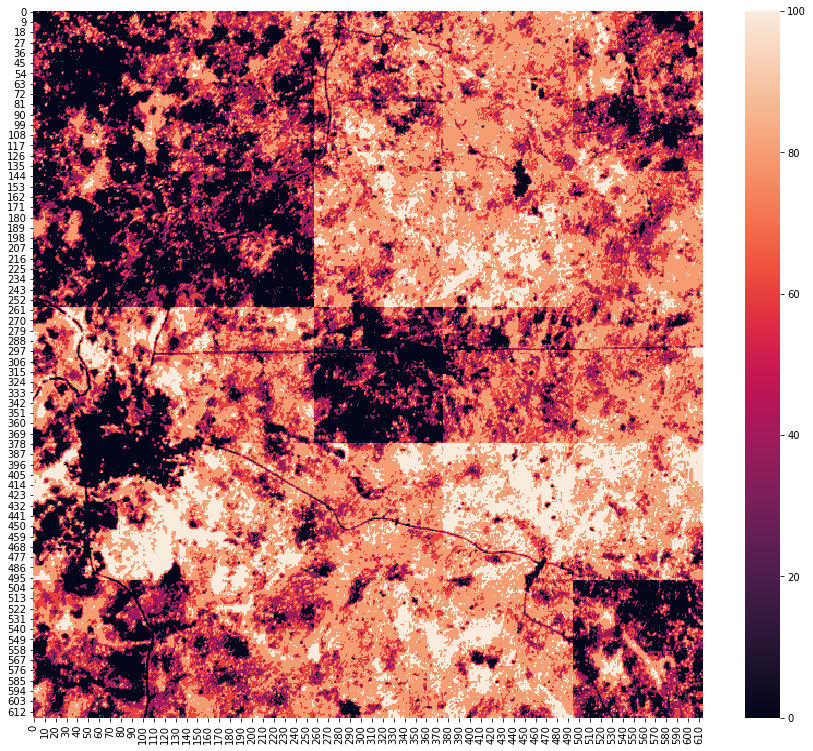

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.figure(figsize=(15,13))

#1650 / 1161
# 1666/1058
# 1633, 1082

x = str(1633)
y = str(1076)

import matplotlib.pyplot as plt
artifact = plt.imread(f"../project-monitoring/tof-output/{x}/{y}/{x}X{y}Y_POST.tif")
artifact = artifact.astype(np.float32)
sns.heatmap(artifact)

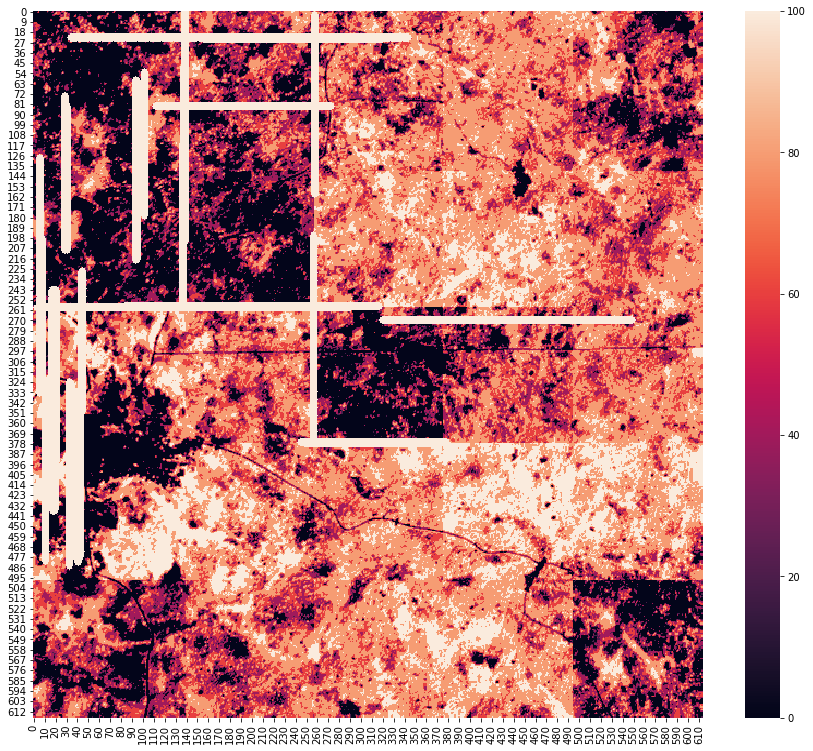

In [8]:
import cv2 as cv
import math

kernel_size = 3
blur = cv.GaussianBlur(artifact,(kernel_size, kernel_size),0)
dst = cv.Canny(blur.astype(np.uint8), 140, 200, None, 3)
    
# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

line_img = np.copy(artifact)


lines = cv.HoughLinesP(dst, 1, np.pi / 2, 60, None, 120, 20)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv.line(line_img,(x1,y1),(x2,y2),(255,0,0),5)
        
lines = cv.HoughLinesP(dst, 1, np.pi, 60, None, 120, 20)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv.line(line_img,(x1,y1),(x2,y2),(255,0,0),5)

%matplotlib inline
plt.figure(figsize=(15,13))
sns.heatmap(line_img, vmax = 100)

In [672]:

def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g
arr = fspecial_gauss(140, 70)
def load_mosaic_predictions(out_folder: str) -> np.ndarray:
    """
    Loads the .npy subtile files in an output folder and mosaics the overlapping predictions
    to return a single .npy file of tree cover for the 6x6 km tile
    Additionally, applies post-processing threshold rules and implements no-data flag of 255
    """
    x_tiles = [int(x) for x in os.listdir(out_folder) if '.DS' not in x]
    max_x = np.max(x_tiles) + 140
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        max_y = np.max(y_tiles) + 140
    predictions = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), np.nan, dtype = np.float32)
    mults = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), 0, dtype = np.float32)
    i = 0
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        for y_tile in y_tiles:
            output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
            if os.path.exists(output_file):
                prediction = np.load(output_file)
                if np.sum(prediction) > 0:
                    prediction = (prediction * 100).T.astype(np.float32)
                    predictions[x_tile: x_tile+140, y_tile:y_tile + 140, i] = prediction
                    mults[x_tile: x_tile+140, y_tile:y_tile + 140, i] = fspecial_gauss(140, 20)
                i += 1
    predictions = predictions.astype(np.float32)
    mults = mults / np.sum(mults, axis = -1)[..., np.newaxis]
    predictions[predictions == 255] = np.nan
    predictions = np.nansum(predictions * mults, axis = -1)
    predictions[np.isnan(predictions)] = 255.
    predictions = predictions.astype(np.uint8)
    return predictions

In [673]:
smooth = load_mosaic_predictions(f"../project-monitoring/tiles/{x}/{y}/processed/")

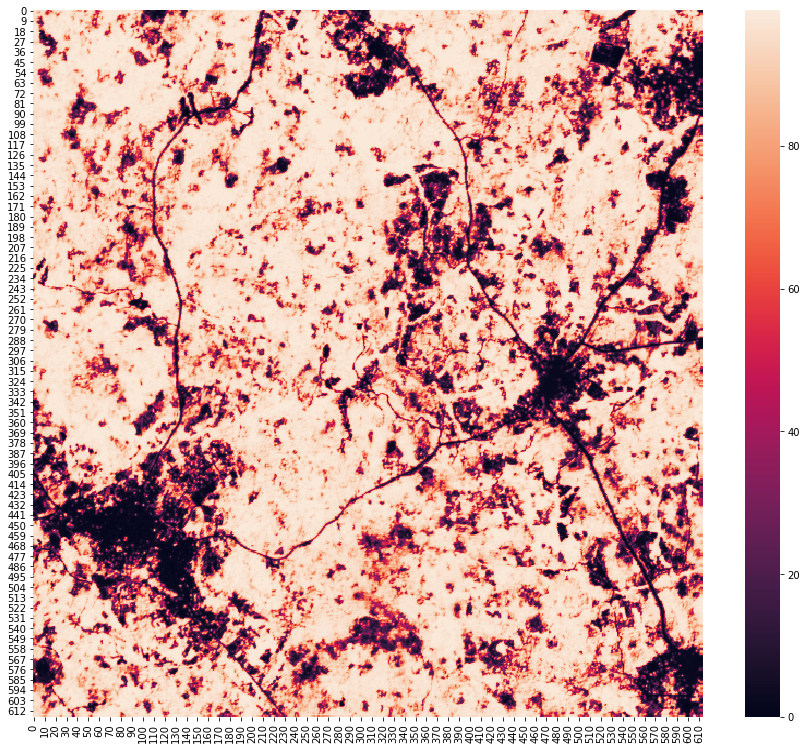

In [674]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,13))
sns.heatmap(smooth.T)

In [9]:
# I/O for fix_artifacts
# download folder
# download list of tiles
# 

In [1]:
import boto3
import os

def download_folder(s3_folder, local_dir, apikey, apisecret, bucket):
    """
    Checks to see if a file/key pair exists locally or on s3 or neither
    """

   
    s3 = boto3.resource('s3', aws_access_key_id=apikey,
         aws_secret_access_key= apisecret)
    bucket = s3.Bucket(bucket)

    for obj in bucket.objects.filter(Prefix=s3_folder):
        print(obj)
        target = obj.key if local_dir is None \
            else os.path.join(local_dir, os.path.relpath(obj.key, s3_folder))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
        

def download_file(s3_file, local_file, apikey, apisecret, bucket):
    """
    Checks to see if a file/key pair exists locally or on s3 or neither
    """

   
    s3 = boto3.resource('s3', aws_access_key_id=apikey,
         aws_secret_access_key= apisecret)
    bucket = s3.Bucket(bucket)

    for obj in bucket.objects.filter(Prefix=s3_file):
        target = obj.key if local_file is None \
            else os.path.join(local_file, os.path.relpath(obj.key, s3_file))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        
        file_name = s3_file.split("/")[-1]
        print(f"Downloading {s3_file} to {local_file + file_name}")
        bucket.download_file(obj.key, target[:-1] + file_name)
        



#download_file(bucket = "tof-output",
#               local_file = "../project-monitoring/",
#               s3_file = "2020/databases/redo-ghana.csv")


    

In [2]:
import pandas as pd
data = pd.read_csv("../redo-ghana.csv")
data.head(5)

,field_1,Y,X,country,Y_tile,X_tile
0,47989,10.972222,-2.027778,Ghana,1161,1649
1,47994,10.972222,-1.750000,Ghana,1161,1654
2,48031,10.916667,-1.805556,Ghana,1160,1653
3,48032,10.916667,-1.750000,Ghana,1160,1654
4,48190,10.694444,-0.638889,Ghana,1156,1674


In [6]:
import yaml
yaml_path = "../../config.yaml"
with open(yaml_path, 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY= key['key']
    AWSKEY = key['awskey']
    AWSSECRET = key['awssecret']
print(f"Successfully loaded key from {yaml_path}")

Successfully loaded key from ../../config.yaml


In [28]:
i = 0
for index, row in data.iterrows():
    x = str(int(row['X_tile']))
    y = str(int(row['Y_tile']))
    local_path = f"../../project-monitoring/tof-output/{str(x)}/{str(y)}/"
    s3_path = f"2020/tiles/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_POST.tif"
    download_file(bucket = "tof-output",
               local_file = local_path,
               apikey = AWSKEY,
               apisecret = AWSSECRET,
               s3_file = s3_path)
    print(i)
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [27]:
import pandas as pd
yaml_path = "../../config.yaml"
with open(yaml_path, 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY= key['key']
    AWSKEY = key['awskey']
    AWSSECRET = key['awssecret']
print(f"Successfully loaded key from {yaml_path}")


data = pd.read_csv("reprocess.csv")
data.head(5)

bucket = "tof-output"
s3 = boto3.client('s3', aws_access_key_id=AWSKEY,
         aws_secret_access_key= AWSSECRET)

for index, row in data.iterrows():
    x = str(int(row['X_tile']))
    y = str(int(row['Y_tile']))
    local_path = f"../../project-monitoring/tof-output/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_v1.tif"
    s3_path = f"2020/tiles/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_v1.tif"
    
    
    try:
        s3.delete_object(Bucket = "tof-output", Key = s3_path)
    except:
        print(f"No file at: {s3_path}")
        continue
    try:
        os.remove(local_path)
    except:
        continue